# **Submission Notebook**



In [1]:
%load_ext autoreload
%autoreload 2
!pip3 install -i https://test.pypi.org/simple/ grp_krml_group6==2024.0.1.0
!pip3 install xgboost

Looking in indexes: https://test.pypi.org/simple/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
from grp_krml_group6.data.sets import pop_target, data_cleaning, roc_curve_plot, distribution_plot, categorical_plot, confusion_matrix_plot, relationship_plot

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
train_file_url = '../data/raw/train.csv'
test_file_url = '../data/raw/test.csv'

In [5]:
train_df = pd.read_csv(train_file_url)
test_df = pd.read_csv(test_file_url)

In [6]:
train_df.shape, test_df.shape

((46618, 64), (4970, 63))

In [7]:
df_cleaned = train_df.copy()
df_clean_test = test_df.copy()

In [8]:
# 1. Drop Irrelevant Features
df_cleaned.drop(columns=['player_id', 'year', 'team'], inplace=True)
df_clean_test.drop(columns=['player_id', 'year', 'team'], inplace=True)

# Dropping columns with a large amount of missing data (e.g., Rec_Rank)
df_cleaned.drop('Rec_Rank', axis=1, inplace=True)
df_clean_test.drop('Rec_Rank', axis=1, inplace=True)

In [9]:
# Example usage for height transformation:
month_mapping = {
    "Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4,
    "May": 5, "Jun": 6, "Jul": 7, "Aug": 8,
    "Sep": 9, "Oct": 10, "Nov": 11, "Dec": 12
}

def convert_height(ht_value):
    try:
        feet, inches = ht_value.split('-')
        inches = month_mapping.get(inches, inches)  # Convert month-like string to a number
        return int(feet) * 12 + int(inches)
    except (ValueError, AttributeError):
        return np.nan

In [10]:
num_cols = ['ast_tov', 'rimmade', 'midmade', 'rim_ratio', 'mid_ratio', 'dunks_ratio', 'pick']
cat_cols = ['num', 'ht', 'yr']

In [11]:
df_cleaned = data_cleaning(df_cleaned, 
                           num_columns = num_cols, 
                           cat_columns = cat_cols, 
                           special_column_transformations={'ht': convert_height})
X_test = data_cleaning(df_clean_test, 
                           num_columns = num_cols, 
                           cat_columns = cat_cols, 
                           special_column_transformations={'ht': convert_height})

In [12]:
# 1. Split the data into features (X) and target (y)
X, y = pop_target(df_cleaned, 'drafted')

In [13]:
# 2. Further split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [14]:
# 3. Define the preprocessing pipeline
categorical_columns = ['conf', 'yr', 'type']  # Adjust as needed
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_columns = [col for col in numerical_columns if col not in categorical_columns]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ])

In [15]:
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)  # Adjust this based on class distribution

In [16]:
# 4. Create the Logistic Regression pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(scale_pos_weight=ratio))
])

In [17]:
param_distributions = {
    'classifier__max_depth': randint(3, 10),  # Max depth of trees
    'classifier__learning_rate': uniform(0.01, 0.3),  # Learning rate
    'classifier__n_estimators': randint(10, 100),  # Number of trees
    'classifier__gamma': uniform(0, 0.5),  # Penalize tree splits
    'classifier__reg_alpha': uniform(0.01, 1),  # L1 regularization (Lasso)
    'classifier__reg_lambda': uniform(0.01, 1),  # L2 regularization (Ridge)
    'classifier__scale_pos_weight': uniform(1, 10),  # Balancing positive and negative classes
}

# Randomized search over the parameter grid
random_search = RandomizedSearchCV(pipeline, param_distributions, n_iter=10, scoring='roc_auc', cv=3, random_state=42)

In [18]:
# 5. Train the model
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['GP',
                                                                                'Min_per',
                                                                                'Ortg',
                                                                                'usg',
                                                                                'eFG',
                                                                                'TS_per',
                                                                                'ORB_per',
                                                                                'DRB_per',
                                                                                'AST_per',
                                                                                'TO_per',
                                                                                'FTM',
                                                                                'FTA',
                                                                                'FT_per',
                                                                                'twoPM',
                                                                                'twoPA',
                                                                                'twoP_per',
                                                                                'TPM',
                                                                                'TPA',
                                                                                'TP_per',
                                                                                'blk_per',
                                                                                'stl_per',
                                                                                'ftr',
                                                                                'ht',
                                                                                'porpag',
                                                                                'adjoe',
                                                                                'pfr',
                                                                                'ast_tov',
                                                                                'rimmade',
                                                                                'r...
                                        'classifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x123e13e50>,
                                        'classifier__reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x131c755d0>,
                                        'classifier__reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x131c75c10>,
                                        'classifier__scale_pos_weight': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x131c76250>},
                   random_state=42, scoring='roc_auc')

In [19]:
random_search.best_params_

{'classifier__gamma': np.float64(0.18727005942368125),
 'classifier__learning_rate': np.float64(0.2952142919229748),
 'classifier__max_depth': 5,
 'classifier__n_estimators': 81,
 'classifier__reg_alpha': np.float64(0.6086584841970366),
 'classifier__reg_lambda': np.float64(0.16601864044243653),
 'classifier__scale_pos_weight': np.float64(2.5599452033620267)}

In [20]:
best_model = random_search.best_estimator_

In [21]:
# 6. Predict on the test set
y_pred = best_model.predict(X_train)
y_pred_proba = best_model.predict_proba(X_train)[:, 1]  # Get the probability estimates for the positive class

In [22]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_train, y_pred))


Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     32321
         1.0       1.00      1.00      1.00       311

    accuracy                           1.00     32632
   macro avg       1.00      1.00      1.00     32632
weighted avg       1.00      1.00      1.00     32632



In [23]:
# 7. Evaluate the model
accuracy = accuracy_score(y_train, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 1.0000


In [24]:
# 8. ROC AUC Score
roc_auc = roc_auc_score(y_train, y_pred_proba)
print(f'\nROC AUC Score: {roc_auc:.4f}')


ROC AUC Score: 1.0000


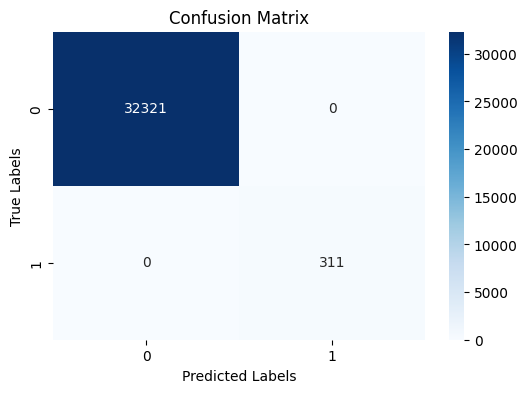

In [25]:
# Confusion Matrix
# Compute the confusion matrix
confusion_matrix_plot(y_train, y_pred)

In [26]:
# 6. Predict on the test set
y_pred_val = best_model.predict(X_val)
y_pred_proba_val = best_model.predict_proba(X_val)[:, 1]  # Get the probability estimates for the positive class

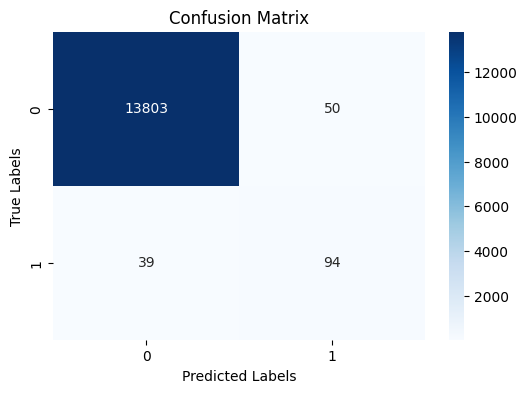

In [27]:
# Confusion Matrix
confusion_matrix_plot(y_val, y_pred_val)

In [28]:
# 8. ROC AUC Score
roc_auc = roc_auc_score(y_val, y_pred_proba_val)
print(f'\nROC AUC Score: {roc_auc:.4f}')


ROC AUC Score: 0.9972


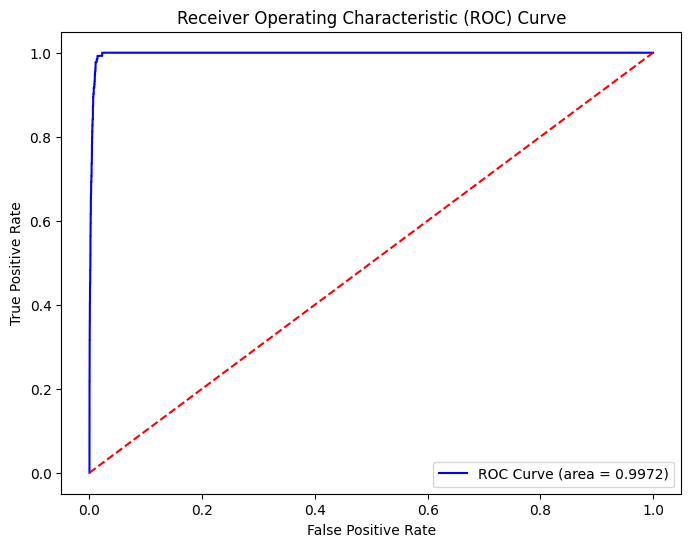

In [29]:
# 9. Plot ROC Curve
roc_curve_plot(y_val, y_pred_proba_val)

In [30]:
test_df['predicted_probability'] = best_model.predict_proba(X_test)[:,1]

In [33]:
test_df[['player_id', 'predicted_probability']].to_csv('submission_grad.csv', index=False)

In [34]:
test_df[['player_id', 'predicted_probability']]

,player_id,predicted_probability
0,23549e01-c1b3-4ca0-a0fd-de9b5d76276b,0.002781
1,52a518bb-b34a-4b43-adee-5e996cb853fa,0.002563
2,ad3d9117-b6bf-4675-ab97-3497acf3e555,0.015060
3,eaf66a5c-6f4c-4070-bc70-a99d731b3740,0.006748
4,55d07491-5bd1-447f-844e-9cb36eaa442e,0.024739
...,...,...
4965,28222513-8a1f-4a48-8fde-16888e9e11ce,0.016825
4966,c32a466d-7a66-47eb-805c-a94e328261bc,0.002213
4967,55f0ddef-9f29-47ae-87b5-da43c687d25c,0.003753
4968,460d6a42-5dbc-48f0-bc94-3650da83f345,0.003753


The model shows strong performance on both the validation 0.97 and test sets 0.91, with a high ROC AUC score and low misclassification rates. However, the difference in performance between the training and test sets indicates potential overfitting. This could be improved by implementing better generalization techniques, such as regularization or addressing class imbalance.